# Konrad Zięba 162624 Projekt Big Data - Analiza sentymentu zbioru danych Amazon reviews
### Link do zbioru: <u>https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews</u>

### Import bibliotek

In [1]:
import dask.dataframe as dd
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from dask.distributed import Client

### Pobranie niezbędnych paczek NLTK do przetwarzania języka naturalnego

In [ ]:

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

### Inicjalizacja dask

In [3]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=2)


# Etap 1: pozyskanie danych

### Wczytanie zbioru treningowego oraz testowego (wcześniej przekonwertowanego z .csv na .parquet)

In [4]:
train = dd.read_parquet("./amazon_reviews/train.parquet", engine='pyarrow', chunksize=500_000)
test = dd.read_parquet("./amazon_reviews/test.parquet", engine='pyarrow', chunksize=500_000)

display(train.head())
display(test.head())

,0,1,2
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


,0,1,2
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


### Nadanie nazw kolumn, ponieważ nie zostały określone w zbiorze danych

In [5]:
train.columns = ["polarity", "title", "text"]
test.columns = ["polarity", "title", "text"]

In [6]:
display(train.head())
display(test.head())

,polarity,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


,polarity,title,text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


### Pozbycie się etykiet, ponieważ model będzie trenowany za pomocą SentimentAnalyzer

In [7]:
train = train.drop("polarity", axis=1)
test = test.drop("polarity", axis=1)

In [8]:
display(train.head())
display(test.head())

,title,text
0,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,Amazing!,This soundtrack is my favorite music of all ti...
3,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


,title,text
0,Great CD,My lovely Pat has one of the GREAT voices of h...
1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


### Próbkowanie do prototypowania

In [109]:
# Próbkowanie danych
# train = train.sample(frac=3_000_000 / len(train), random_state=42)
# test = test.sample(frac=600_000 / len(test), random_state=42)

# display(train.head())
# display(test.head())



## Etap 2: analiza eksploracyjna i preprocessing danych

## Usunięcie brakujących danych ze zbiorów

In [ ]:
train = train.dropna()
test = test.dropna()

In [ ]:
## Łączenie 

In [11]:
train["combined"] = train["title"] + " " + train["text"]
test["combined"] = test["title"] + " " + test["text"]

In [12]:
# Przekształcenie tekstu na małe litery
train["combined"] = train["combined"].str.lower()
test["combined"] = test["combined"].str.lower()

In [13]:
train.head()

,title,text,combined
0,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,stuning even for the non-gamer this sound trac...
1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,the best soundtrack ever to anything. i'm read...
2,Amazing!,This soundtrack is my favorite music of all ti...,amazing! this soundtrack is my favorite music ...
3,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,excellent soundtrack i truly like this soundtr...
4,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...","remember, pull your jaw off the floor after he..."


### Usuwanie interpunkcji

In [14]:
def remove_punctuation(text):
    if pd.isna(text):
        return text
    return text.translate(str.maketrans("", "", string.punctuation))

train["combined"] = train["combined"].map(remove_punctuation, meta=("combined", "object"))
test["combined"] = test["combined"].map(remove_punctuation, meta=("combined", "object"))

In [15]:
display(train.head())

display(train.head())

,title,text,combined
0,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,stuning even for the nongamer this sound track...
1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,the best soundtrack ever to anything im readin...
2,Amazing!,This soundtrack is my favorite music of all ti...,amazing this soundtrack is my favorite music o...
3,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,excellent soundtrack i truly like this soundtr...
4,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",remember pull your jaw off the floor after hea...


,title,text,combined
0,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,stuning even for the nongamer this sound track...
1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,the best soundtrack ever to anything im readin...
2,Amazing!,This soundtrack is my favorite music of all ti...,amazing this soundtrack is my favorite music o...
3,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,excellent soundtrack i truly like this soundtr...
4,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",remember pull your jaw off the floor after hea...


### Usuwanie "stop words"

In [16]:
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    if pd.isna(text):
        return text
    return " ".join([word for word in text.split() if word not in stop_words])

train["combined"] = train["combined"].map(remove_stopwords, meta=("combined", "object"))
test["combined"] = test["combined"].map(remove_stopwords, meta=("combined", "object"))

train.head(15)

,title,text,combined
0,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,stuning even nongamer sound track beautiful pa...
1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,best soundtrack ever anything im reading lot r...
2,Amazing!,This soundtrack is my favorite music of all ti...,amazing soundtrack favorite music time hands i...
3,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,excellent soundtrack truly like soundtrack enj...
4,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",remember pull jaw floor hearing youve played g...
5,an absolute masterpiece,I am quite sure any of you actually taking the...,absolute masterpiece quite sure actually takin...
6,Buyer beware,"This is a self-published book, and if you want...",buyer beware selfpublished book want know whyr...
7,Glorious story,I loved Whisper of the wicked saints. The stor...,glorious story loved whisper wicked saints sto...
8,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...,five star book finished reading whisper wicked...
9,Whispers of the Wicked Saints,This was a easy to read book that made me want...,whispers wicked saints easy read book made wan...


### Lematyzacja tekstu

In [17]:
from textblob import Word, TextBlob

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if not text or not isinstance(text, str):
        return ""

    lemmatizer = WordNetLemmatizer()
    try:
        blob = TextBlob(text)
        lemmatized_words = []
        for word, tag in blob.tags:
            pos = tag[0].lower()
            pos = pos if pos in ['a', 'n', 'v'] else 'n'
            lemmatized_words.append(lemmatizer.lemmatize(word, pos))
        return " ".join(lemmatized_words)
    except Exception as e:
        print(f"Error processing text: {text}\nException: {e}")
        return text

train["combined"] = train["combined"].map(lemmatize_text, meta=("combined", "object"))
test["combined"] = test["combined"].map(lemmatize_text, meta=("combined", "object"))

train.head(15)

,title,text,combined
0,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,stun even nongamer sound track beautiful paint...
1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,best soundtrack ever anything im reading lot r...
2,Amazing!,This soundtrack is my favorite music of all ti...,amaze soundtrack favorite music time hand inte...
3,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,excellent soundtrack truly like soundtrack enj...
4,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",remember pull jaw floor hear youve played game...
5,an absolute masterpiece,I am quite sure any of you actually taking the...,absolute masterpiece quite sure actually take ...
6,Buyer beware,"This is a self-published book, and if you want...",buyer beware selfpublished book want know whyr...
7,Glorious story,I loved Whisper of the wicked saints. The stor...,glorious story love whisper wicked saint story...
8,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...,five star book finish read whisper wicked sain...
9,Whispers of the Wicked Saints,This was a easy to read book that made me want...,whisper wicked saint easy read book make want ...


### Usunięcie kolumn `title` oraz `text` dla przyśpieszenia operacji .compute() oraz zaoszczędzenia pamięci

In [18]:
train = train.drop(columns=['title', 'text'])
test = test.drop(columns=['title', 'text'])

### Zapisanie danych w pamięci RAM

In [19]:
train = train.persist()
test = test.persist()

### Konwersja do Pandas w celu dalszej obróbki i wizualizacji

In [20]:
train_pd = train.compute()
test_pd = test.compute()

### Przykład działania lematyzacji tekstu. Przykład: `rocks -> rock`, `working -> word`, `better -> good`

In [21]:
single_text = 'love gold better making movies pretty'
print("Original text:", single_text)

lemmatized_text = lemmatize_text(single_text)
print("Lemmatized text:", lemmatized_text)


Original text: love gold better making movies pretty
Lemmatized text: love gold better make movie pretty


### **Analiza sentymentu** przy użyciu `SentimentIntensityAnalyzer`

In [22]:
# Inicjalizacja analizatora sentymentu
sentiment_analyzer = SentimentIntensityAnalyzer()

def calculate_sentiment(text):
    return sentiment_analyzer.polarity_scores(text)["compound"]

# Zastosowanie analizy sentymentu do danych
train["score_text"] = train["combined"].map(calculate_sentiment, meta=("score_text", "float"))
test["score_text"] = test["combined"].map(calculate_sentiment, meta=("score_text", "float"))

### Przypisanie etykiet. Sentyment `pozytywny: 1`, `negatywny: 0`

In [23]:
def assign_label(score):
    return 1 if score > 0 else 0

train["label_text"] = train["score_text"].map(assign_label, meta=("label_text", "int"))
test["label_text"] = test["score_text"].map(assign_label, meta=("label_text", "int"))

In [24]:
train.head(15)

,combined,score_text,label_text
0,stun even nongamer sound track beautiful paint...,0.9136,1
1,best soundtrack ever anything im reading lot r...,0.9559,1
2,amaze soundtrack favorite music time hand inte...,0.9857,1
3,excellent soundtrack truly like soundtrack enj...,0.9801,1
4,remember pull jaw floor hear youve played game...,0.9831,1
5,absolute masterpiece quite sure actually take ...,0.9894,1
6,buyer beware selfpublished book want know whyr...,0.1962,1
7,glorious story love whisper wicked saint story...,0.9917,1
8,five star book finish read whisper wicked sain...,0.9687,1
9,whisper wicked saint easy read book make want ...,0.8442,1


### Przejście do pandas do wizualizacji i treningu

In [25]:
train = train.compute()
test = test.compute()

# Etap 3: trening modelu ML

### Wizualizacja rozkładu sentymentów

/Users/konradzieba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


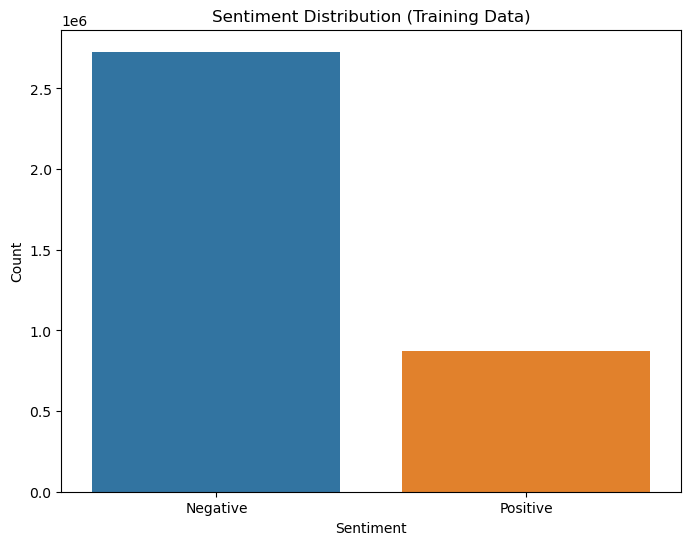

In [26]:
sentiment_counts = train["label_text"].value_counts()
sentiment_labels = ["Negative", "Positive"]

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_labels, y=sentiment_counts)
plt.title("Sentiment Distribution (Training Data)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

## Wizualizacje

### Generowanie chmur słów

2025-01-17 13:25:09,009 - distributed.scheduler - WARNING - Worker failed to heartbeat for 353s; attempting restart: <WorkerState 'tcp://127.0.0.1:53316', name: 0, status: running, memory: 0, processing: 0>
2025-01-17 13:25:09,180 - distributed.scheduler - WARNING - Worker failed to heartbeat for 353s; attempting restart: <WorkerState 'tcp://127.0.0.1:53317', name: 1, status: running, memory: 0, processing: 0>
2025-01-17 13:25:09,195 - distributed.scheduler - WARNING - Worker failed to heartbeat for 353s; attempting restart: <WorkerState 'tcp://127.0.0.1:53320', name: 2, status: running, memory: 0, processing: 0>
2025-01-17 13:25:09,255 - distributed.scheduler - WARNING - Worker failed to heartbeat for 353s; attempting restart: <WorkerState 'tcp://127.0.0.1:53323', name: 3, status: running, memory: 0, processing: 0>
2025-01-17 13:25:14,004 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-01-17 13:25:14,041 - distributed.nanny - WARNING - Worker

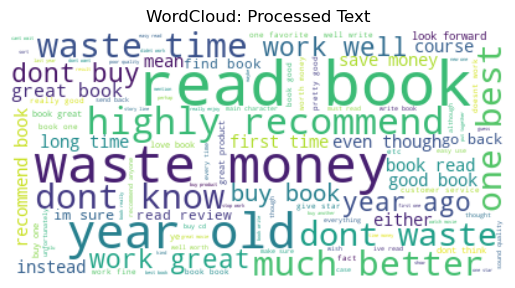

In [27]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")

all_text_processed = " ".join(train_pd["combined"].astype(str))
wordcloud.generate(all_text_processed)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud: Processed Text")
plt.show()

### Wizualizacja rozkładu długości tekstu kolumny `combined`

/Users/konradzieba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


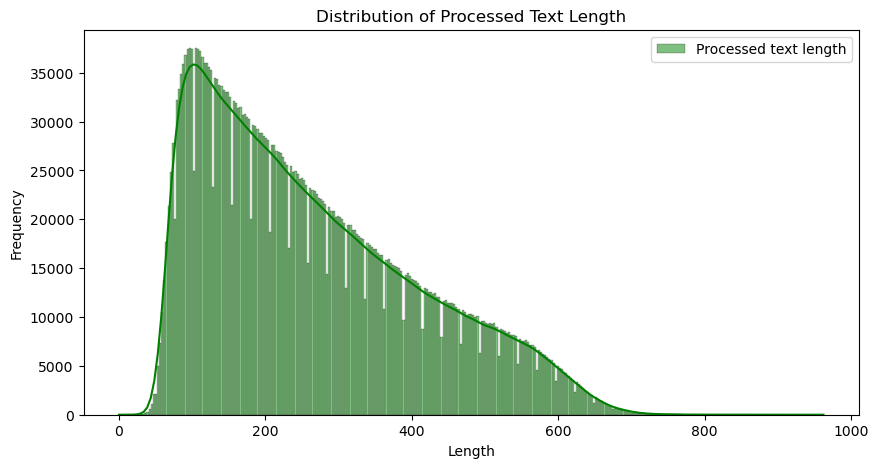

In [28]:
plt.figure(figsize=(10, 5))
sns.histplot(train_pd["combined"].apply(len), kde=True, color="green", label="Processed text length")
plt.title("Distribution of Processed Text Length")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Przygotowanie danych do treningu

In [29]:
y_train = train["label_text"]
X_train = train["combined"]
y_test = test["label_text"]
X_test = test["combined"]

### Wektoryzacja tekstu

In [30]:
vectorizer = TfidfVectorizer().fit(X_train)
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Trening modelu i ewaluacja

In [31]:
model = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
y_predict = model.predict(X_test_tfidf)

# Ewaluacja projektu - Raport modelu
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85     96817
           1       0.95      0.97      0.96    303159

    accuracy                           0.93    399976
   macro avg       0.92      0.90      0.91    399976
weighted avg       0.93      0.93      0.93    399976



### Wizualizacja statystyk raportu klasyfikacji

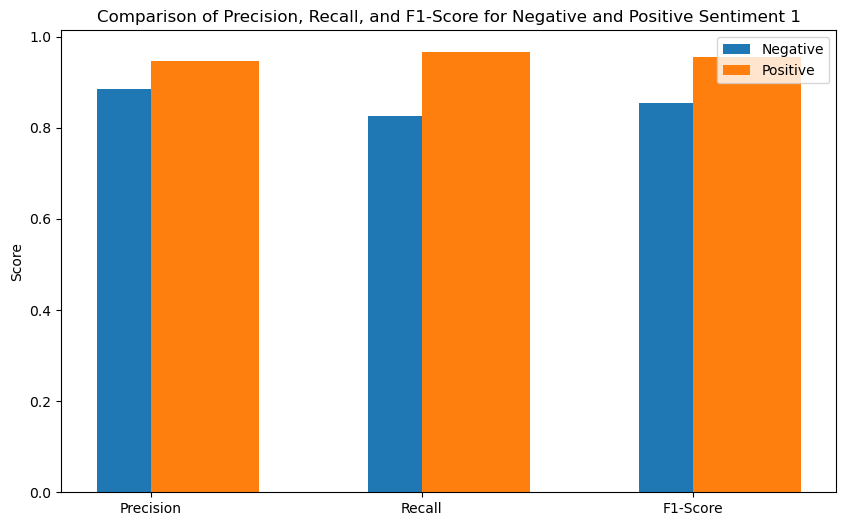

In [151]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_0 = precision_score(y_test, y_predict, pos_label=0)
recall_0 = recall_score(y_test, y_predict, pos_label=0)
f1_0 = f1_score(y_test, y_predict, pos_label=0)

precision_1 = precision_score(y_test, y_predict, pos_label=1)
recall_1 = recall_score(y_test, y_predict, pos_label=1)
f1_1 = f1_score(y_test, y_predict, pos_label=1)

metrics = ['Precision', 'Recall', 'F1-Score']
class_0_values = [precision_0, recall_0, f1_0]
class_1_values = [precision_1, recall_1, f1_1]

x = range(len(metrics))
plt.figure(figsize=(10, 6))
plt.bar(x, class_0_values, width=0.4, label='Negative', align='center')
plt.bar(x, class_1_values, width=0.4, label='Positive', align='edge')
plt.xticks(x, metrics)
plt.title("Comparison of Precision, Recall, and F1-Score for Negative and Positive Sentiment 1")
plt.ylabel("Score")
plt.legend()
plt.show()


### Wizualizacja 10 najczęściej występujących słów w tekstach o pozytywnym i negatywnym sentymencie

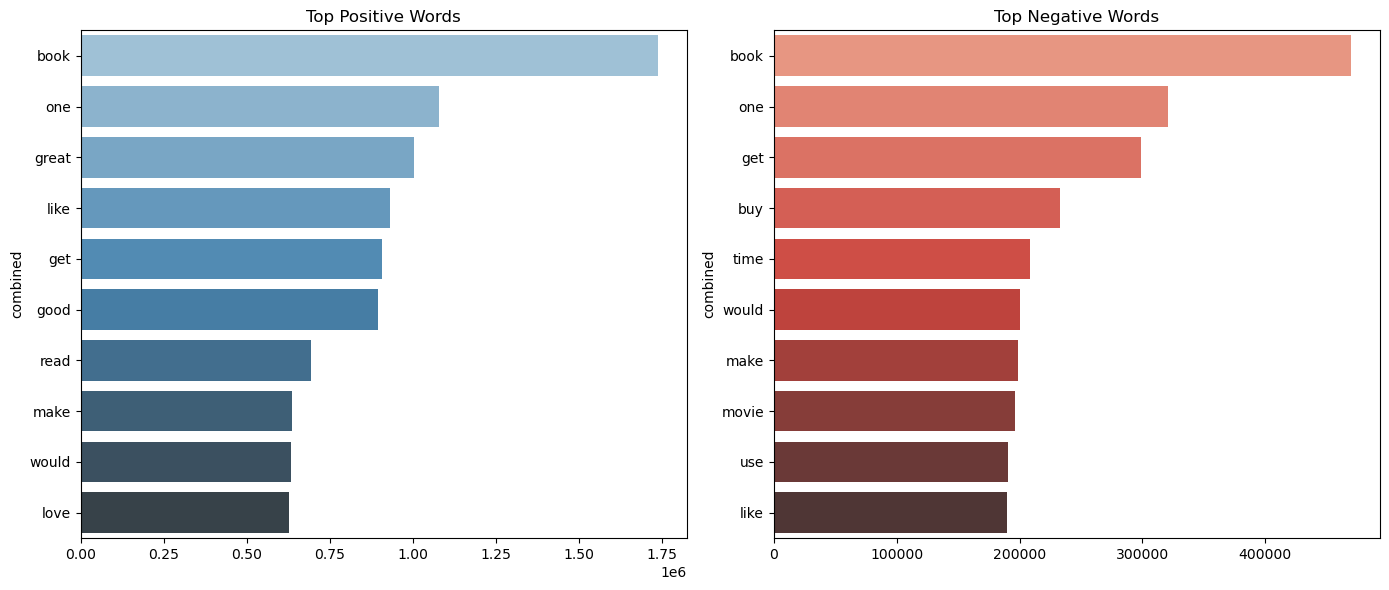

In [33]:
positive_words = train[train['label_text'] == 1]['combined'].str.split().explode().value_counts().head(10)
negative_words = train[train['label_text'] == 0]['combined'].str.split().explode().value_counts().head(10)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=positive_words.values, y=positive_words.index, ax=axes[0], palette='Blues_d')
axes[0].set_title("Top Positive Words")
sns.barplot(x=negative_words.values, y=negative_words.index, ax=axes[1], palette='Reds_d')
axes[1].set_title("Top Negative Words")
plt.tight_layout()
plt.show()


### Wizualizacja 10 słów o najwyższym pozytywnym i negatywnym wpływie na predykcję modelu regresji logistycznej, na podstawie ich współczynników.

/Users/konradzieba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


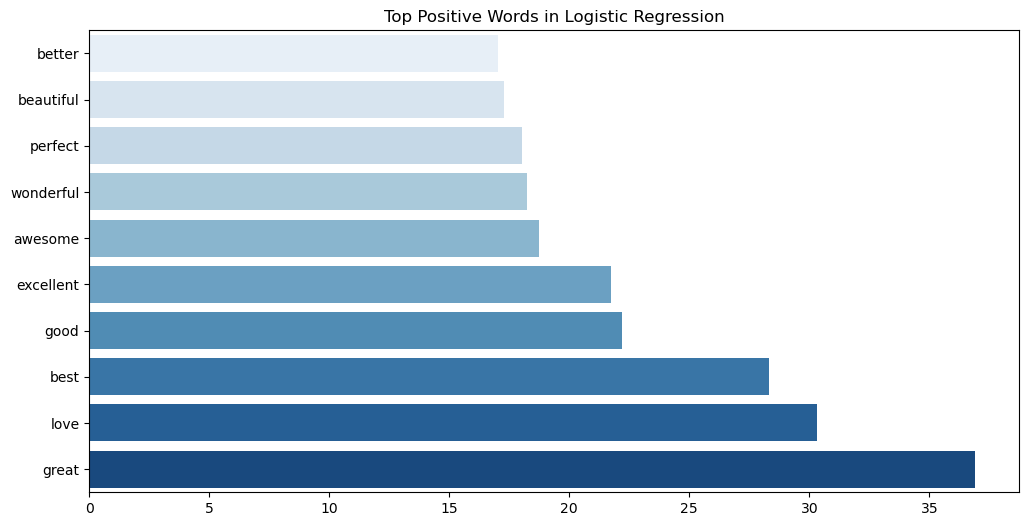

/Users/konradzieba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


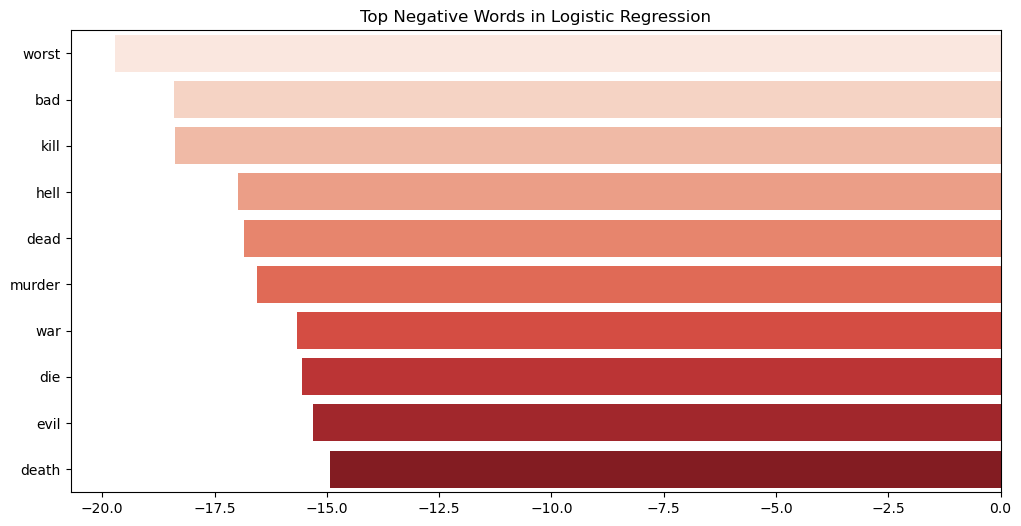

In [34]:
coefficients = model.coef_.flatten()
top_positive_coefficients = coefficients.argsort()[-10:]
top_negative_coefficients = coefficients.argsort()[:10]


features = vectorizer.get_feature_names_out()
top_positive_words = [features[i] for i in top_positive_coefficients]
top_negative_words = [features[i] for i in top_negative_coefficients]

plt.figure(figsize=(12, 6))
sns.barplot(x=coefficients[top_positive_coefficients], y=top_positive_words, palette="Blues")
plt.title("Top Positive Words in Logistic Regression")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=coefficients[top_negative_coefficients], y=top_negative_words, palette="Reds")
plt.title("Top Negative Words in Logistic Regression")
plt.show()


### Wykres krzywej ROC <i>(Receiver Operating Characteristic)</i> dla modelu, wizualizując zależność między odsetkiem fałszywie pozytywnych wyników (FPR) a odsetkiem prawdziwie pozytywnych wyników (TPR), oraz wylicza pole pod krzywą (AUC) jako miarę jakości klasyfikatora.

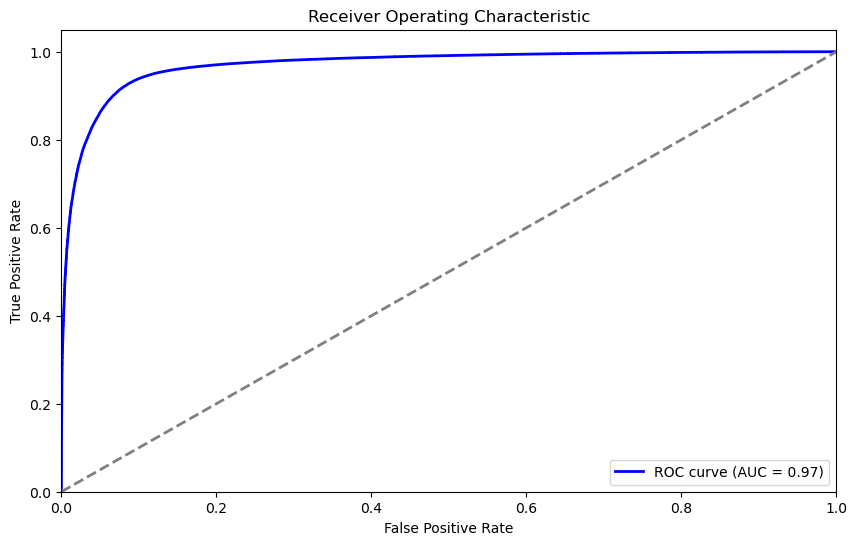

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### Macierz pomyłek dla przewidywań modelu

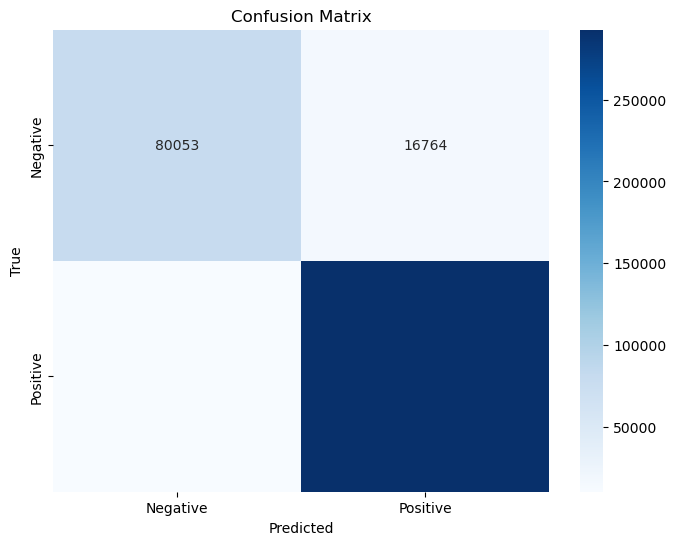

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_predict)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Przykładowa losowo wybrana predykcja

In [195]:
random_text = train["combined"].sample(1).iloc[0]
new_text = vectorizer.transform([random_text])
prediction = model.predict(new_text)
print(f"Text: {random_text}\nPrediction: {'Positive' if prediction == 1 else 'Negative'}")


Text: waste money dont waste money buy brand wipe warmer let alone one use especially baby lionhart dry half wipe time refill also doesnt provide much warmth wipesmaybe room temperature use wipe warmer return twice two week give broke stop heat wipe dont even think daughter even notice stop use themat least never seem bother cold one besides feel container harbor bacteria mold moist inside may even healthy
Prediction: Negative


# Etap 4: Utrwalenie modelu - wczytanie i testy

### Utrwalenie modelu i wektoryzatora za pomocą joblib

In [92]:
import joblib

joblib.dump(vectorizer, 'tfidf_vectorizer_full.pkl')

joblib.dump(model, 'sentiment_model_full.pkl')

['sentiment_model_full.pkl']

### Funkcja wczytująca model i wektoryzator, przetwarzająca tekst oraz przewidująca sentyment

In [94]:
def predict_sentiment_batch(data):
    vectorizer = joblib.load('tfidf_vectorizer_full.pkl')
    model = joblib.load('sentiment_model_full.pkl')

    predictions = []

    for item in data:
        title = item.get("title", "")
        text = item.get("text", "")

        combined_text = title + " " + text

        # Przetwarzanie tekstu
        combined_text = combined_text.lower()
        combined_text = remove_punctuation(combined_text)
        combined_text = remove_stopwords(combined_text)
        combined_text = lemmatize_text(combined_text)

        # Wektoryzacja
        text_tfidf = vectorizer.transform([combined_text])

        # Predykcja sentymentu
        prediction = model.predict(text_tfidf)
        sentiment = "Positive" if prediction == 1 else "Negative"
        
        predictions.append({
            "title": title,
            "text": text,
            "sentiment": sentiment
        })

    return predictions


### Testowanie na własnych danych

In [96]:
# Przykładowe dane wejściowe
data = [
    {"title": "Great product!", "text": "I really loved this product. It worked perfectly for my needs."},
    {"title": "Bad quality", "text": "The product broke after one use. Very disappointing."},
    {"title": "Amazing experience", "text": "This is by far the best service I've received. Highly recommend!"},
    {"title": "Not worth the price", "text": "The product didn’t live up to my expectations. Overpriced for the quality."},
    {"title": "Satisfied with my purchase", "text": "The item is exactly what I was looking for. Very happy with it."},
    {"title": "Terrible customer service", "text": "I had issues with my order and customer service was unhelpful."},
    {"title": "Worth every penny", "text": "Great value for the money. Excellent product!"},
    {"title": "Disappointed", "text": "I thought the quality would be better. Not what I expected."},
    {"title": "Great value", "text": "This product exceeded my expectations. Great quality for the price."},
    {"title": "Worst purchase ever", "text": "It stopped working after a few days. I regret buying it."},
    {"title": "Highly recommend", "text": "Amazing product! I will definitely buy it again."},
    {"title": "Do not buy", "text": "It broke after one use. Very poor quality."},
    {"title": "Perfect for my needs", "text": "Just what I was looking for. Works perfectly."},
    {"title": "Not as described", "text": "The product doesn't match the description. I am very disappointed."}
]

# Predykcja sentymentu dla wszystkich słowników w liście
predictions = predict_sentiment_batch(data)

for prediction in predictions:
    print(f"Title: {prediction['title']}\nText: {prediction['text']}\nSentiment: {prediction['sentiment']}\n")

Title: Great product!
Text: I really loved this product. It worked perfectly for my needs.
Sentiment: Positive

Title: Bad quality
Text: The product broke after one use. Very disappointing.
Sentiment: Negative

Title: Amazing experience
Text: This is by far the best service I've received. Highly recommend!
Sentiment: Positive

Title: Not worth the price
Text: The product didn’t live up to my expectations. Overpriced for the quality.
Sentiment: Positive

Title: Satisfied with my purchase
Text: The item is exactly what I was looking for. Very happy with it.
Sentiment: Positive

Title: Terrible customer service
Text: I had issues with my order and customer service was unhelpful.
Sentiment: Negative

Title: Worth every penny
Text: Great value for the money. Excellent product!
Sentiment: Positive

Title: Disappointed
Text: I thought the quality would be better. Not what I expected.
Sentiment: Negative

Title: Great value
Text: This product exceeded my expectations. Great quality for the pri